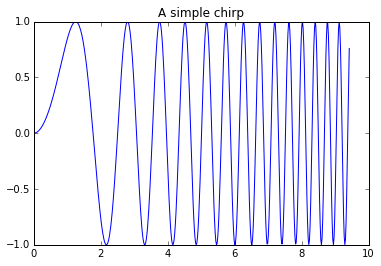

In [267]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp');

In [268]:
import os

from wndcharm.FeatureSpace import FeatureSpace
f=FeatureSpace.NewFromFileOfFiles( os.path.expanduser('data/medial_7_6_8_delta_womac.fof'), long=True )
f.ToFitFile('data/medial_7_6_8_delta_womac.fit')

LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 gr

In [269]:
dmat = f.ContiguousDataMatrix()
print (dmat)
print (f.data_list)
print (f._contiguous_ground_truth_labels)
print (f._contiguous_ground_truth_values)

[[  2.46300000e+03   5.44220000e-02   2.34303000e-01 ...,  -4.20041000e+04
    1.33342000e+05   7.16966000e-01]
 [  2.46100000e+03   3.82510000e-02   4.73540000e-02 ...,  -5.46250000e+04
    1.36239000e+05   7.25326000e-01]
 [  2.46300000e+03   2.86680000e-02   2.27273000e-01 ...,  -3.12424000e+04
    1.15157000e+05   7.13205000e-01]
 ..., 
 [  2.40200000e+03   7.63360000e-02   1.62866000e-01 ...,  -6.03631000e+04
    1.30804000e+05   7.21693000e-01]
 [  2.45000000e+03   1.28302000e-01   7.62710000e-02 ...,  -5.37427000e+04
    1.35765000e+05   7.17335000e-01]
 [  2.43000000e+03   1.49250000e-02   4.86660000e-02 ...,  -4.15241000e+04
    1.06458000e+05   7.17794000e-01]]
[array([[  2.46300000e+03,   5.44220000e-02,   2.34303000e-01, ...,
         -4.20041000e+04,   1.33342000e+05,   7.16966000e-01],
       [  2.46100000e+03,   3.82510000e-02,   4.73540000e-02, ...,
         -5.46250000e+04,   1.36239000e+05,   7.25326000e-01],
       [  2.46300000e+03,   2.86680000e-02,   2.27273000e-0

In [270]:
print (f.class_names)
class_vals = [float(x) for x in f.class_names]
print (class_vals)

['0', '12', '37.1', '13', '27', '41', '11', '18', '33.4', '25.5', '17.8', '20', '22', '35.6', '30', '19', '20.1', '35.1', '30.2', '17', '27.1', '39.7', '12.2', '24.3', '33', '24.2', '17.7', '40', '24', '49', '43.7', '23', '14', '19.3']
[0.0, 12.0, 37.1, 13.0, 27.0, 41.0, 11.0, 18.0, 33.4, 25.5, 17.8, 20.0, 22.0, 35.6, 30.0, 19.0, 20.1, 35.1, 30.2, 17.0, 27.1, 39.7, 12.2, 24.3, 33.0, 24.2, 17.7, 40.0, 24.0, 49.0, 43.7, 23.0, 14.0, 19.3]


In [271]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
from sklearn.lda import LDA

In [272]:
def normalize (train, test):
    norm_train_set = train.copy() 
    mins, maxs = normalize_by_columns (norm_train_set)
    norm_test_set = test.copy() 
    normalize_by_columns (norm_test_set, mins, maxs)
    return (norm_train_set, norm_test_set)

def normalize_by_columns ( full_stack, mins = None, maxs = None ):
    """This is a global function to normalize a matrix by columns.
    If numpy 1D arrays of mins and maxs are provided, the matrix will be normalized against these ranges
    Otherwise, the mins and maxs will be determined from the matrix, and the matrix will be normalized
    against itself. The mins and maxs will be returned as a tuple.
    Out of range matrix values will be clipped to min and max (including +/- INF)
    zero-range columns will be set to 0.
    NANs in the columns will be set to 0.
    The normalized output range is hard-coded to 0-100
    """
    # Edge cases to deal with:
    # Range determination:
    # 1. features that are nan, inf, -inf
    # max and min determination must ignore invalid numbers
    # nan -> 0, inf -> max, -inf -> min
    # Normalization:
    # 2. feature values outside of range
    # values clipped to range (-inf to min -> min, max to inf -> max) - leaves nan as nan
    # 3. feature ranges that are 0 result in nan feature values
    # 4. all nan feature values set to 0

    # Turn off numpy warnings, since we're taking care of invalid values explicitly
    oldsettings = np.seterr(all='ignore')
    if (mins is None or maxs is None):
        # mask out NANs and +/-INFs to compute min/max
        full_stack_m = np.ma.masked_invalid (full_stack, copy=False)
        maxs = full_stack_m.max (axis=0)
        mins = full_stack_m.min (axis=0)

    # clip the values to the min-max range (NANs are left, but +/- INFs are taken care of)
    full_stack.clip (mins, maxs, full_stack)
    # remake a mask to account for NANs and divide-by-zero from max == min
    full_stack_m = np.ma.masked_invalid (full_stack, copy=False)

    # Normalize
    full_stack_m -= mins
    full_stack_m /= (maxs - mins)
    # Left over NANs and divide-by-zero from max == min become 0
    # Note the deep copy to change the numpy parameter in-place.
    full_stack[:] = full_stack_m.filled (0) * 100.0

    # return settings to original
    np.seterr(**oldsettings)

    return (mins,maxs)

In [273]:
def stand (train, test):
    scaler = StandardScaler()
    new_train_set = scaler.fit_transform(train)
    new_test_set = scaler.transform(test)
    return (new_train_set,new_test_set)

In [274]:
def round_robin_iteration (index, data_matrix_list):
    '''Does a leave N out, where N is the number of classes.
    The class with the smallest number of samples -1 (nsamples - 1) determines training set size.
    Picks nsamples-1 for training and testing from a circular list starting at index.
    Index ranges from 0 to the product of number of samples in each class.
    data_matrix_list is a list of data matrixes, with one matrix per class'''
    lengths = [m.shape[0] for m in data_matrix_list]
    nclasses = len(lengths)
    max_samples = min (lengths) - 1
    indexes = [0] * nclasses
    cl_index = index
    for i in range (nclasses-1,0,-1):
        indexes[i] = cl_index / lengths[i]
        cl_index -= (indexes[i] * lengths[i])
    indexes[0] = cl_index
    indexes = list(reversed(indexes))
    
    train_mats = []
    test_mats = []
    for class_num in range(nclasses):
        class_indexes = [ (count+indexes[class_num]+1) % lengths[class_num] for count in range (max_samples) ]
        train_mats.append (np.take (data_matrix_list[class_num], class_indexes, axis=0) )
        test_mats.append (np.take (data_matrix_list[class_num], [indexes[class_num]], axis=0) )
    return (train_mats, test_mats)

In [275]:
dat_mat = np.mgrid[0:8,0:5]
print (dat_mat)
(train,test) = round_robin_iteration (19,dat_mat)
print ('-------')
print (test)
print (train)

[[[0 0 0 0 0]
  [1 1 1 1 1]
  [2 2 2 2 2]
  [3 3 3 3 3]
  [4 4 4 4 4]
  [5 5 5 5 5]
  [6 6 6 6 6]
  [7 7 7 7 7]]

 [[0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]]]
-------
[array([[2, 2, 2, 2, 2]]), array([[0, 1, 2, 3, 4]])]
[array([[3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1]]), array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])]


In [276]:
def list_to_contig_mat (data_matrix_list, class_vals):
    data_mat_contig = np.vstack (data_matrix_list)
    class_vals_vec_list = []
    for class_idx in range (len(data_matrix_list)):
        class_vals_vec_list += [class_vals[class_idx]] * len (data_matrix_list[class_idx])
    class_vals_contig = np.asarray(class_vals_vec_list)
    return (data_mat_contig,class_vals_contig)

In [277]:
def Fisher(split):
    """Takes a FeatureSet_Discrete as input and calculates a Fisher score for
    each feature. Returns a newly instantiated instance of FisherFeatureWeights.

    For:
    N = number of classes
    F = number of features
    It = total number of images in training set
    Ic = number of images in a given class
    """

    if split == None:
        import inspect
        form_str = 'You passed in a None as a training set to the function {0}.{1}'	
        raise ValueError( form_str.format( cls.__name__, inspect.stack()[1][3] ) )

    # we deal with NANs/INFs separately, so turn off numpy warnings about invalid floats.
    oldsettings = np.seterr(all='ignore')

    def get_train_3d (self):
        if self.train_3d is None:
            self.train_3d = get_class_mat_list (self.train_set, self.train_classed_labels)
        return (self.train_3d)

    def get_test_3d (self):
        if self.test_3d is None:
            self.test_3d = get_class_mat_list (self.test_set, self.test_classed_labels)
        return (self.test_3d)

    #class_mats = split.get_train_3d()
    class_mats = get_class_mat_list (split.train_set, split.train_classed_labels)
    # 1D matrix 1 * F
    population_means = np.mean( split.train_set, axis = 0 )
    n_classes = class_mats.shape[0]
    n_features = split.train_set.shape[1]

    # 2D matrix shape N * F
    intra_class_means = np.empty( [n_classes, n_features] )
    # 2D matrix shape N * F
    intra_class_variances = np.empty( [n_classes, n_features] )

    class_index = 0
    for class_feature_matrix in class_mats:
        intra_class_means[ class_index ] = np.mean( class_feature_matrix, axis=0 )
    # Note that by default, numpy divides by N instead of the more common N-1, hence ddof=1.
        intra_class_variances[ class_index ] = np.var( class_feature_matrix, axis=0, ddof=1 )
        class_index += 1

    # 1D matrix 1 * F
    # we deal with NANs/INFs separately, so turn off numpy warnings about invalid floats.
    # for the record, in numpy:
    # 1./0. = inf, 0./inf = 0., 1./inf = 0. inf/0. = inf, inf/inf = nan
    # 0./0. = nan, nan/0. = nan, 0/nan = nan, nan/nan = nan, nan/inf = nan, inf/nan = nan
    # We can't deal with NANs only, must also deal with pos/neg infs
    # The masked array allows for dealing with "invalid" floats, which includes nan and +/-inf
    denom = np.mean( intra_class_variances, axis = 0 )
    denom[denom == 0] = np.nan
    feature_weights_m = np.ma.masked_invalid (
            ( np.square( population_means - intra_class_means ).sum( axis = 0 ) /
        (n_classes - 1) ) / denom
        )
    # return numpy error settings to original
    np.seterr(**oldsettings)

    # the filled(0) method of the masked array sets all nan and infs to 0
    fisher_values = feature_weights_m.filled(0).tolist()

    return (fisher_values)

In [278]:
def Pearson(train_mat, train_vals):
    """Calculate regression parameters and correlation statistics that fully define
    a continuous classifier.

    At present the feature weights are proportional the Pearson correlation coefficient
    for each given feature."""

    from scipy import stats

    # Known issue: running stats.linregress() with np.seterr (all='raise') has caused
    # arithmetic underflow (FloatingPointError: 'underflow encountered in stdtr' )
    # I think this is something we can safely ignore in this function, and return settings
    # back to normal at the end. -CEC
    np.seterr (under='ignore')    

    pearson_coeffs = np.zeros(train_mat.shape[1])

    for feature_index in range( train_mat.shape[1] ):
        slope, intercept, pearson_coeff, p_value, std_err = stats.linregress(
            train_vals, train_mat[:,feature_index]
        )

        pearson_coeffs[feature_index] = pearson_coeff
# We're just returning the pearsons^2 now...
#    pearson_values = [val*val / r_val_squared_sum for val in pearson_coeffs ]
#    pearson_coeffs = (pearson_coeffs * pearson_coeffs) / r_val_squared_sum
    pearson_coeffs *= pearson_coeffs
    

    # Reset numpy
    np.seterr (all='raise')

    return pearson_coeffs

In [279]:
def marg_prob_to_pred_value (marg_probs, class_vals):
    weighted = np.array(marg_probs)*np.array(class_vals)
    return (np.sum(weighted))

def WND5(contig_train_mat, contig_test_mat, contig_train_vals):
    n_test_samples = contig_test_mat.shape[0]
    n_train_samples = contig_train_mat.shape[0]
    predicted_classes = np.zeros(n_test_samples)
    predicted_values = np.zeros(n_test_samples)
    
    epsilon = np.finfo( np.float ).eps
    testimg_idx = 0
    trainimg_idx = 0
    
    for testimg_idx in range( n_test_samples ):
        # initialize
        class_dists = {}
        class_counts = {}
        classnames_list = []

        for trainimg_idx in range( n_train_samples ):
            train_class_label = contig_train_vals[trainimg_idx]
            if not train_class_label in class_dists:
                class_dists [train_class_label] = 0.0
                class_counts[train_class_label] = 0.0
                classnames_list.append (train_class_label)

            dists = np.absolute (contig_train_mat [trainimg_idx] - contig_test_mat [testimg_idx])
            w_dist = np.sum( dists )
            if w_dist > epsilon:
                class_counts[train_class_label] += 1.0
            else:
                continue

            w_dist = np.sum( np.square( dists ) )
            # The exponent -5 is the "5" in "WND5"
            class_dists[ train_class_label ] += w_dist ** -5

        
        class_idx = 0
        class_similarities = [0]*len(class_dists)
        for class_label in classnames_list:
            class_similarities[class_idx] = class_dists[class_label] / class_counts[class_label]
            class_idx += 1

        norm_factor = sum( class_similarities )
        marg_probs = np.array( [ x / norm_factor for x in class_similarities ] )

        predicted_class_idx = marg_probs.argmax()

        predicted_classes[testimg_idx] = classnames_list[ predicted_class_idx ]
        predicted_values[testimg_idx] = marg_prob_to_pred_value (marg_probs, classnames_list)

    return (predicted_classes, predicted_values)

In [280]:
def sort_by_weight (the_mat, feature_weights):
    i = np.argsort(feature_weights)
    sort_mat = the_mat[:,i]
    sort_mat = np.fliplr(sort_mat)
    return (sort_mat)

def weigh_sort(train, test, feature_weights):
    weigh_train = np.multiply (norm_train, feature_weights)
    weigh_test = np.multiply (norm_test, feature_weights)

    sorted_train = sort_by_weight (weigh_train, feature_weights)
    sorted_test = sort_by_weight (weigh_test, feature_weights)
    return (sorted_train, sorted_test)

In [281]:
def rand_forest_clf (contig_train_mat, contig_test_mat, contig_train_vals, rnd_state = None):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 30, random_state = rnd_state)
    clf.fit(contig_train_mat, contig_train_vals)
    predicted_classes = clf.predict(contig_test_mat)
    return (predicted_classes)
def rand_forest_reg (contig_train_mat, contig_test_mat, contig_train_vals, rnd_state = None):
    from sklearn.ensemble import RandomForestRegressor
    forest = RandomForestRegressor(n_estimators=30, random_state = rnd_state)
    forest.fit(contig_train_mat, contig_train_vals)
    predicted = forest.predict(contig_test_mat)
    return (predicted)

In [282]:
def lin_reg(contig_train_mat, contig_test_mat, contig_train_vals):
    from sklearn.linear_model import LinearRegression
    lin_reg = LinearRegression()
    lin_reg.fit(contig_train_mat, contig_train_vals)
    predicted = lin_reg.predict(contig_test_mat)
    return (predicted)

In [283]:
dmat = f.ContiguousDataMatrix()
print (dmat)
print (f.data_list)
print (f._contiguous_ground_truth_labels)
print (f._contiguous_ground_truth_values)

[[  2.46300000e+03   5.44220000e-02   2.34303000e-01 ...,  -4.20041000e+04
    1.33342000e+05   7.16966000e-01]
 [  2.46100000e+03   3.82510000e-02   4.73540000e-02 ...,  -5.46250000e+04
    1.36239000e+05   7.25326000e-01]
 [  2.46300000e+03   2.86680000e-02   2.27273000e-01 ...,  -3.12424000e+04
    1.15157000e+05   7.13205000e-01]
 ..., 
 [  2.40200000e+03   7.63360000e-02   1.62866000e-01 ...,  -6.03631000e+04
    1.30804000e+05   7.21693000e-01]
 [  2.45000000e+03   1.28302000e-01   7.62710000e-02 ...,  -5.37427000e+04
    1.35765000e+05   7.17335000e-01]
 [  2.43000000e+03   1.49250000e-02   4.86660000e-02 ...,  -4.15241000e+04
    1.06458000e+05   7.17794000e-01]]
[array([[  2.46300000e+03,   5.44220000e-02,   2.34303000e-01, ...,
         -4.20041000e+04,   1.33342000e+05,   7.16966000e-01],
       [  2.46100000e+03,   3.82510000e-02,   4.73540000e-02, ...,
         -5.46250000e+04,   1.36239000e+05,   7.25326000e-01],
       [  2.46300000e+03,   2.86680000e-02,   2.27273000e-0

In [284]:
iter_idx = 1

print dmat
dmat2 = np.delete (dmat,[iter_idx],axis=0)
print
print np.asarray([dmat2[iter_idx]])

class_vals = f._contiguous_ground_truth_values
print class_vals
contig_train_vals = np.delete (class_vals, [iter_idx])
contig_test_vals = np.asarray ([class_vals[iter_idx]])
print contig_train_vals
print contig_test_vals

[[  2.46300000e+03   5.44220000e-02   2.34303000e-01 ...,  -4.20041000e+04
    1.33342000e+05   7.16966000e-01]
 [  2.46100000e+03   3.82510000e-02   4.73540000e-02 ...,  -5.46250000e+04
    1.36239000e+05   7.25326000e-01]
 [  2.46300000e+03   2.86680000e-02   2.27273000e-01 ...,  -3.12424000e+04
    1.15157000e+05   7.13205000e-01]
 ..., 
 [  2.40200000e+03   7.63360000e-02   1.62866000e-01 ...,  -6.03631000e+04
    1.30804000e+05   7.21693000e-01]
 [  2.45000000e+03   1.28302000e-01   7.62710000e-02 ...,  -5.37427000e+04
    1.35765000e+05   7.17335000e-01]
 [  2.43000000e+03   1.49250000e-02   4.86660000e-02 ...,  -4.15241000e+04
    1.06458000e+05   7.17794000e-01]]

[[  2.46300000e+03   2.86680000e-02   2.27273000e-01 ...,  -3.12424000e+04
    1.15157000e+05   7.13205000e-01]]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 37.1, 13.0, 13.0, 27.0, 41.0, 11.0, 18.0, 33.4, 25.5, 17.8,

In [285]:
nfeatures = 1000
niter = dmat.shape[0]
class_vals = f._contiguous_ground_truth_values
n_correct = np.asarray( [0]*2)
(train,test) = round_robin_iteration (0,f.data_list)
print ('Train class sizes : {}'.format(dmat.shape[0]-1))
print ('Features          : {}'.format(nfeatures))
print ('Iterations        : {}'.format(niter))
predictions = []
actual = []
for iter_idx in range ( niter ):
    # Split
    contig_train_mat = np.delete(dmat,[iter_idx],axis=0)
    contig_test_mat = np.asarray([dmat[iter_idx]])

    contig_train_vals = np.delete (class_vals, [iter_idx])
    contig_test_vals = np.asarray ([class_vals[iter_idx]])

    # Normalize
    (norm_train, norm_test) = normalize (contig_train_mat, contig_test_mat)
    
    # Reduce
    feature_weights = Pearson(norm_train, contig_train_vals)
    (sorted_train, sorted_test) = weigh_sort (norm_train, norm_test, feature_weights)

    # Classify
    preds,pred_val = WND5(sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals)
    #pred_val = rand_forest_reg (sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals, iter_idx)
    #pred_val = lin_reg (sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals)
    predictions.append (pred_val[0])
    actual.append (class_vals[iter_idx])
    print ('Iteration {}; Predictions: {}; actual: {}'.format(iter_idx, predictions[-1], actual[-1]))

score, p_value = pearsonr(predictions, actual)
score *= score
print ('R^2: {}, p-value: {}'.format (score, p_value))

Train class sizes : 67
Features          : 1000
Iterations        : 68
Iteration 0; Predictions: 8.07309220527; actual: 0.0
Iteration 1; Predictions: 15.6846715703; actual: 0.0
Iteration 2; Predictions: 10.6642170704; actual: 0.0
Iteration 3; Predictions: 14.6765331801; actual: 0.0
Iteration 4; Predictions: 12.7261757653; actual: 0.0
Iteration 5; Predictions: 12.7261757653; actual: 0.0
Iteration 6; Predictions: 18.7983357259; actual: 0.0
Iteration 7; Predictions: 25.45248113; actual: 0.0
Iteration 8; Predictions: 13.8133721843; actual: 0.0
Iteration 9; Predictions: 21.8712429271; actual: 0.0
Iteration 10; Predictions: 20.153050893; actual: 0.0
Iteration 11; Predictions: 21.9328778106; actual: 0.0
Iteration 12; Predictions: 17.2827691602; actual: 0.0
Iteration 13; Predictions: 14.6666248737; actual: 0.0
Iteration 14; Predictions: 27.7825700637; actual: 0.0
Iteration 15; Predictions: 27.7231619987; actual: 0.0
Iteration 16; Predictions: 19.4462152914; actual: 0.0
Iteration 17; Prediction

# wnd5
Train class sizes : 67
Features          : 1000
Iterations        : 68
Iteration 0; Predictions: 8.07309220527; actual: 0.0
Iteration 1; Predictions: 15.6846715703; actual: 0.0
Iteration 2; Predictions: 10.6642170704; actual: 0.0
Iteration 3; Predictions: 14.6765331801; actual: 0.0
Iteration 4; Predictions: 12.7261757653; actual: 0.0
Iteration 5; Predictions: 12.7261757653; actual: 0.0
Iteration 6; Predictions: 18.7983357259; actual: 0.0
Iteration 7; Predictions: 25.45248113; actual: 0.0
Iteration 8; Predictions: 13.8133721843; actual: 0.0
Iteration 9; Predictions: 21.8712429271; actual: 0.0
Iteration 10; Predictions: 20.153050893; actual: 0.0
Iteration 11; Predictions: 21.9328778106; actual: 0.0
Iteration 12; Predictions: 17.2827691602; actual: 0.0
Iteration 13; Predictions: 14.6666248737; actual: 0.0
Iteration 14; Predictions: 27.7825700637; actual: 0.0
Iteration 15; Predictions: 27.7231619987; actual: 0.0
Iteration 16; Predictions: 19.4462152914; actual: 0.0
Iteration 17; Predictions: 22.4474999542; actual: 0.0
Iteration 18; Predictions: 21.8173144213; actual: 0.0
Iteration 19; Predictions: 31.9945241023; actual: 0.0
Iteration 20; Predictions: 17.0144110145; actual: 0.0
Iteration 21; Predictions: 23.3808721756; actual: 0.0
Iteration 22; Predictions: 20.6562178789; actual: 0.0
Iteration 23; Predictions: 17.768489224; actual: 0.0
Iteration 24; Predictions: 11.7785666326; actual: 0.0
Iteration 25; Predictions: 19.6223816416; actual: 0.0
Iteration 26; Predictions: 33.1541632385; actual: 0.0
Iteration 27; Predictions: 19.2870387638; actual: 0.0
Iteration 28; Predictions: 23.8994402634; actual: 12.0
Iteration 29; Predictions: 20.0080673889; actual: 37.1
Iteration 30; Predictions: 39.7994479223; actual: 13.0
Iteration 31; Predictions: 27.5534446412; actual: 13.0
Iteration 32; Predictions: 25.5871102621; actual: 27.0
Iteration 33; Predictions: 14.1396556747; actual: 41.0
Iteration 34; Predictions: 29.6190226061; actual: 11.0
Iteration 35; Predictions: 19.0783876339; actual: 18.0
Iteration 36; Predictions: 32.7629561138; actual: 33.4
Iteration 37; Predictions: 21.7286375165; actual: 25.5
Iteration 38; Predictions: 16.6793282677; actual: 17.8
Iteration 39; Predictions: 25.3991074243; actual: 20.0
Iteration 40; Predictions: 22.4112190609; actual: 22.0
Iteration 41; Predictions: 26.1286706172; actual: 35.6
Iteration 42; Predictions: 23.0821144983; actual: 30.0
Iteration 43; Predictions: 29.8791244281; actual: 19.0
Iteration 44; Predictions: 19.5968841036; actual: 20.1
Iteration 45; Predictions: 24.0542368657; actual: 35.1
Iteration 46; Predictions: 15.7018704395; actual: 30.2
Iteration 47; Predictions: 24.4633481818; actual: 17.0
Iteration 48; Predictions: 24.2560338934; actual: 27.1
Iteration 49; Predictions: 16.4760486463; actual: 39.7
Iteration 50; Predictions: 18.0194929185; actual: 12.2
Iteration 51; Predictions: 25.273864821; actual: 18.0
Iteration 52; Predictions: 27.4068423129; actual: 24.3
Iteration 53; Predictions: 24.4468711528; actual: 33.0
Iteration 54; Predictions: 24.7389052277; actual: 24.2
Iteration 55; Predictions: 28.0615938424; actual: 17.7
Iteration 56; Predictions: 23.6070385874; actual: 40.0
Iteration 57; Predictions: 12.4298427358; actual: 24.0
Iteration 58; Predictions: 28.1988191344; actual: 22.0
Iteration 59; Predictions: 26.9940049903; actual: 49.0
Iteration 60; Predictions: 29.6496575366; actual: 43.7
Iteration 61; Predictions: 13.0049635356; actual: 40.0
Iteration 62; Predictions: 1.71367354242; actual: 24.0
Iteration 63; Predictions: 19.2807182338; actual: 23.0
Iteration 64; Predictions: 12.2279054134; actual: 18.0
Iteration 65; Predictions: 22.6658068315; actual: 35.6
Iteration 66; Predictions: 27.2186253608; actual: 14.0
Iteration 67; Predictions: 19.7216226236; actual: 19.3
R^2: 0.025621122081, p-value: 0.192270457138


Train class sizes : 67
Features          : 15
Iterations        : 68
Iteration 0; Predictions: -0.363704071417; actual: 0.0
Iteration 1; Predictions: 0.838834422119; actual: 0.0
Iteration 2; Predictions: 0.367916519606; actual: 0.0
Iteration 3; Predictions: 0.61592784943; actual: 0.0
Iteration 4; Predictions: -0.430848982547; actual: 0.0
Iteration 5; Predictions: -0.430848982547; actual: 0.0
Iteration 6; Predictions: 1.68136863238; actual: 0.0
Iteration 7; Predictions: 2.14574839416; actual: 0.0
Iteration 8; Predictions: -0.142104278572; actual: 0.0
Iteration 9; Predictions: 0.230966513484; actual: 0.0
Iteration 10; Predictions: 0.547289049598; actual: 0.0
Iteration 11; Predictions: 0.684491735839; actual: 0.0
Iteration 12; Predictions: 0.361664007205; actual: 0.0
Iteration 13; Predictions: 0.831611158148; actual: 0.0
Iteration 14; Predictions: 1.48638585041; actual: 0.0
Iteration 15; Predictions: 0.768037065858; actual: 0.0
Iteration 16; Predictions: 0.817013923817; actual: 0.0
Iteration 17; Predictions: -0.197170243909; actual: 0.0
Iteration 18; Predictions: 1.02341999213; actual: 0.0
Iteration 19; Predictions: 1.11762401743; actual: 0.0
Iteration 20; Predictions: 0.418547203436; actual: 0.0
Iteration 21; Predictions: 2.06663645028; actual: 0.0
Iteration 22; Predictions: 0.228880388558; actual: 0.0
Iteration 23; Predictions: -0.0540666915222; actual: 0.0
Iteration 24; Predictions: 0.570354418943; actual: 0.0
Iteration 25; Predictions: -0.327619722271; actual: 0.0
Iteration 26; Predictions: 1.09593800836; actual: 0.0
Iteration 27; Predictions: 1.11879371121; actual: 0.0
Iteration 28; Predictions: 1.15762768975; actual: 1.0
Iteration 29; Predictions: 0.910703528097; actual: 3.0
Iteration 30; Predictions: 2.57552511708; actual: 1.0
Iteration 31; Predictions: 0.624512428449; actual: 1.0
Iteration 32; Predictions: 2.20137656481; actual: 2.0
Iteration 33; Predictions: 1.8472546494; actual: 4.0
Iteration 34; Predictions: 2.69721559274; actual: 1.0
Iteration 35; Predictions: 1.01355173463; actual: 1.0
Iteration 36; Predictions: 2.81930388956; actual: 3.0
Iteration 37; Predictions: 1.64175937408; actual: 2.0
Iteration 38; Predictions: 0.512714479804; actual: 1.0
Iteration 39; Predictions: 3.1655911926; actual: 1.0
Iteration 40; Predictions: 2.56228342201; actual: 2.0
Iteration 41; Predictions: 1.83304057407; actual: 3.0
Iteration 42; Predictions: 1.45903313021; actual: 2.0
Iteration 43; Predictions: 1.79888182656; actual: 1.0
Iteration 44; Predictions: 0.706905312341; actual: 2.0
Iteration 45; Predictions: 1.94805174047; actual: 3.0
Iteration 46; Predictions: 1.64764979236; actual: 2.0
Iteration 47; Predictions: 2.11660885658; actual: 1.0
Iteration 48; Predictions: 2.79759115696; actual: 2.0
Iteration 49; Predictions: 1.05020455457; actual: 3.0
Iteration 50; Predictions: 0.498414033393; actual: 1.0
Iteration 51; Predictions: -0.565670999993; actual: 1.0
Iteration 52; Predictions: 1.30635332937; actual: 2.0
Iteration 53; Predictions: 2.08781121177; actual: 3.0
Iteration 54; Predictions: 2.11056717045; actual: 2.0
Iteration 55; Predictions: 2.01297288001; actual: 1.0
Iteration 56; Predictions: 1.76846145146; actual: 3.0
Iteration 57; Predictions: 1.88682307817; actual: 2.0
Iteration 58; Predictions: 1.76397964809; actual: 2.0
Iteration 59; Predictions: 1.7184026813; actual: 4.0
Iteration 60; Predictions: 2.08709961768; actual: 4.0
Iteration 61; Predictions: 2.17914615062; actual: 3.0
Iteration 62; Predictions: -0.140174332917; actual: 2.0
Iteration 63; Predictions: 1.26121404055; actual: 2.0
Iteration 64; Predictions: 0.301914109078; actual: 1.0
Iteration 65; Predictions: 0.919494131771; actual: 3.0
Iteration 66; Predictions: 0.985797251757; actual: 1.0
Iteration 67; Predictions: 1.134861697; actual: 1.0
R^2: 0.257591460265, p-value: 9.98754155143e-06

WND5 delta WOMAC Train class sizes : 67
Features          : 100
Iterations        : 68
Iteration 0; Predictions: 0.550663064546; actual: 0.0
Iteration 1; Predictions: 7.2671354061; actual: 0.0
Iteration 2; Predictions: 0.274108186227; actual: 0.0
Iteration 3; Predictions: 0.632047365581; actual: 0.0
Iteration 4; Predictions: 0.178626743462; actual: 0.0
Iteration 5; Predictions: 0.178626743462; actual: 0.0
Iteration 6; Predictions: 25.1438341205; actual: 0.0
Iteration 7; Predictions: 35.5280094506; actual: 0.0
Iteration 8; Predictions: 2.06506201178; actual: 0.0
Iteration 9; Predictions: 27.4646026485; actual: 0.0
Iteration 10; Predictions: 14.1655458335; actual: 0.0
Iteration 11; Predictions: 19.6888266242; actual: 0.0
Iteration 12; Predictions: 16.4334922932; actual: 0.0
Iteration 13; Predictions: 2.44438944219; actual: 0.0
Iteration 14; Predictions: 33.9744018127; actual: 0.0
Iteration 15; Predictions: 16.9732729029; actual: 0.0
Iteration 16; Predictions: 13.7804112225; actual: 0.0
Iteration 17; Predictions: 13.6669442444; actual: 0.0
Iteration 18; Predictions: 35.5128726696; actual: 0.0
Iteration 19; Predictions: 11.3210857604; actual: 0.0
Iteration 20; Predictions: 11.0214890267; actual: 0.0
Iteration 21; Predictions: 24.2227155379; actual: 0.0
Iteration 22; Predictions: 8.73011569592; actual: 0.0
Iteration 23; Predictions: 10.0722706507; actual: 0.0
Iteration 24; Predictions: 3.77052707328; actual: 0.0
Iteration 25; Predictions: 5.2635304292; actual: 0.0
Iteration 26; Predictions: 40.0846065637; actual: 0.0
Iteration 27; Predictions: 3.20975883345; actual: 0.0
Iteration 28; Predictions: 24.7852407131; actual: 12.0
Iteration 29; Predictions: 13.4405390902; actual: 37.1
Iteration 30; Predictions: 29.7503398124; actual: 13.0
Iteration 31; Predictions: 22.7688348051; actual: 13.0
Iteration 32; Predictions: 29.6965443914; actual: 27.0
Iteration 33; Predictions: 17.5055429439; actual: 41.0
Iteration 34; Predictions: 20.1061784568; actual: 11.0
Iteration 35; Predictions: 8.05524450775; actual: 18.0
Iteration 36; Predictions: 23.1863832271; actual: 33.4
Iteration 37; Predictions: 21.8517422054; actual: 25.5
Iteration 38; Predictions: 13.6073000508; actual: 17.8
Iteration 39; Predictions: 34.626944017; actual: 20.0
Iteration 40; Predictions: 21.0527406559; actual: 22.0
Iteration 41; Predictions: 39.2497061197; actual: 35.6
Iteration 42; Predictions: 26.838644646; actual: 30.0
Iteration 43; Predictions: 16.7659823429; actual: 19.0
Iteration 44; Predictions: 21.5859991669; actual: 20.1
Iteration 45; Predictions: 34.4053295525; actual: 35.1
Iteration 46; Predictions: 17.9078259635; actual: 30.2
Iteration 47; Predictions: 33.2145976195; actual: 17.0
Iteration 48; Predictions: 26.44719679; actual: 27.1
Iteration 49; Predictions: 14.7076266915; actual: 39.7
Iteration 50; Predictions: 17.9959655238; actual: 12.2
Iteration 51; Predictions: 25.0150402999; actual: 18.0
Iteration 52; Predictions: 28.9949180524; actual: 24.3
Iteration 53; Predictions: 34.846669773; actual: 33.0
Iteration 54; Predictions: 25.847125744; actual: 24.2
Iteration 55; Predictions: 30.6661627183; actual: 17.7
Iteration 56; Predictions: 18.9661221141; actual: 40.0
Iteration 57; Predictions: 23.1326172999; actual: 24.0
Iteration 58; Predictions: 27.3665024494; actual: 22.0
Iteration 59; Predictions: 32.3741422247; actual: 49.0
Iteration 60; Predictions: 28.3427363853; actual: 43.7
Iteration 61; Predictions: 13.4068028688; actual: 40.0
Iteration 62; Predictions: 0.000697327865554; actual: 24.0
Iteration 63; Predictions: 19.8921839437; actual: 23.0
Iteration 64; Predictions: 12.2066980016; actual: 18.0
Iteration 65; Predictions: 16.0112884411; actual: 35.6
Iteration 66; Predictions: 20.3083487882; actual: 14.0
Iteration 67; Predictions: 17.8671100694; actual: 19.3
R^2: 0.140226297076, p-value: 0.00165514611213

WND5 500 features delta womac
Train class sizes : 39
Features          : 500
Iterations        : 40
Iteration 0; Predictions: 23.5493950505; actual: 12.0
Iteration 1; Predictions: 27.6500479383; actual: 37.1
Iteration 2; Predictions: 38.4348340927; actual: 13.0
Iteration 3; Predictions: 31.0363263112; actual: 13.0
Iteration 4; Predictions: 23.337795507; actual: 27.0
Iteration 5; Predictions: 23.6231138917; actual: 41.0
Iteration 6; Predictions: 26.023003065; actual: 11.0
Iteration 7; Predictions: 25.2555316193; actual: 18.0
Iteration 8; Predictions: 24.0168380751; actual: 33.4
Iteration 9; Predictions: 27.0372672733; actual: 25.5
Iteration 10; Predictions: 25.0138741919; actual: 17.8
Iteration 11; Predictions: 28.128433289; actual: 20.0
Iteration 12; Predictions: 26.1963453511; actual: 22.0
Iteration 13; Predictions: 22.1178662056; actual: 35.6
Iteration 14; Predictions: 22.118865088; actual: 30.0
Iteration 15; Predictions: 23.0162726147; actual: 19.0
Iteration 16; Predictions: 23.9536293032; actual: 20.1
Iteration 17; Predictions: 22.9287235682; actual: 35.1
Iteration 18; Predictions: 13.048607787; actual: 30.2
Iteration 19; Predictions: 23.5562568261; actual: 17.0
Iteration 20; Predictions: 23.9572419809; actual: 27.1
Iteration 21; Predictions: 21.3257338343; actual: 39.7
Iteration 22; Predictions: 18.4507984255; actual: 12.2
Iteration 23; Predictions: 20.6600242927; actual: 18.0
Iteration 24; Predictions: 25.4691502696; actual: 24.3
Iteration 25; Predictions: 22.0820529388; actual: 33.0
Iteration 26; Predictions: 18.4503276698; actual: 24.2
Iteration 27; Predictions: 25.2433968851; actual: 17.7
Iteration 28; Predictions: 26.2540714484; actual: 40.0
Iteration 29; Predictions: 15.6255011585; actual: 24.0
Iteration 30; Predictions: 27.4590350288; actual: 22.0
Iteration 31; Predictions: 24.6286476006; actual: 49.0
Iteration 32; Predictions: 22.7251714305; actual: 43.7
Iteration 33; Predictions: 13.5349802037; actual: 40.0
Iteration 34; Predictions: 23.2613810154; actual: 24.0
Iteration 35; Predictions: 21.8831333067; actual: 23.0
Iteration 36; Predictions: 16.5313387488; actual: 18.0
Iteration 37; Predictions: 25.2655483197; actual: 35.6
Iteration 38; Predictions: 23.4115370106; actual: 14.0
Iteration 39; Predictions: 19.6916067552; actual: 19.3
R^2: 0.0407714320522, p-value: 0.21149226021

WND5 discrete WOMAC score
Train class sizes : 67
Features          : 500
Iterations        : 68
Iteration 0; Predictions: 2.04666666667; actual: 0.0
Iteration 1; Predictions: 4.46; actual: 0.0
Iteration 2; Predictions: 7.46833333333; actual: 1.0
Iteration 3; Predictions: 4.32666666667; actual: 0.0
Iteration 4; Predictions: 1.39333333333; actual: 0.0
Iteration 5; Predictions: 2.35666666667; actual: 1.0
Iteration 6; Predictions: 6.28222222222; actual: 0.0
Iteration 7; Predictions: 20.0966666667; actual: 0.0
Iteration 8; Predictions: 0.833333333333; actual: 2.0
Iteration 9; Predictions: 13.76; actual: 0.0
Iteration 10; Predictions: 10.1666666667; actual: 0.0
Iteration 11; Predictions: 22.67; actual: 0.0
Iteration 12; Predictions: 7.29; actual: 0.0
Iteration 13; Predictions: 5.45555555556; actual: 0.0
Iteration 14; Predictions: 35.3633333333; actual: 0.0
Iteration 15; Predictions: 27.3833333333; actual: 0.0
Iteration 16; Predictions: 9.80888888889; actual: 0.0
Iteration 17; Predictions: 16.4533333333; actual: 0.0
Iteration 18; Predictions: 24.18; actual: 1.0
Iteration 19; Predictions: 26.1366666667; actual: 0.0
Iteration 20; Predictions: 6.32; actual: 0.0
Iteration 21; Predictions: 21.9266666667; actual: 0.0
Iteration 22; Predictions: 16.6933333333; actual: 0.0
Iteration 23; Predictions: 11.7466666667; actual: 0.0
Iteration 24; Predictions: 9.72055555556; actual: 0.0
Iteration 25; Predictions: 17.3666666667; actual: 0.0
Iteration 26; Predictions: 11.2066666667; actual: 0.0
Iteration 27; Predictions: 8.54666666667; actual: 0.0
Iteration 28; Predictions: 24.7033333333; actual: 14.0
Iteration 29; Predictions: 4.97; actual: 40.1
Iteration 30; Predictions: 34.47; actual: 13.0
Iteration 31; Predictions: 24.7733333333; actual: 13.0
Iteration 32; Predictions: 27.9266666667; actual: 35.0
Iteration 33; Predictions: 8.77666666667; actual: 43.0
Iteration 34; Predictions: 26.2366666667; actual: 19.0
Iteration 35; Predictions: 16.2966666667; actual: 22.0
Iteration 36; Predictions: 33.5166666667; actual: 41.4
Iteration 37; Predictions: 11.6966666667; actual: 33.5
Iteration 38; Predictions: 7.48444444444; actual: 17.8
Iteration 39; Predictions: 25.9866666667; actual: 20.0
Iteration 40; Predictions: 24.74; actual: 22.0
Iteration 41; Predictions: 26.33; actual: 35.6
Iteration 42; Predictions: 23.2633333333; actual: 35.0
Iteration 43; Predictions: 30.1166666667; actual: 27.0
Iteration 44; Predictions: 27.2233333333; actual: 25.1
Iteration 45; Predictions: 23.21; actual: 41.1
Iteration 46; Predictions: 16.5; actual: 30.2
Iteration 47; Predictions: 29.99; actual: 19.0
Iteration 48; Predictions: 23.8366666667; actual: 28.1
Iteration 49; Predictions: 15.1433333333; actual: 39.7
Iteration 50; Predictions: 15.8577777778; actual: 15.4
Iteration 51; Predictions: 25.6666666667; actual: 21.0
Iteration 52; Predictions: 27.92; actual: 30.3
Iteration 53; Predictions: 19.95; actual: 36.1
Iteration 54; Predictions: 16.7866666667; actual: 28.4
Iteration 55; Predictions: 21.0133333333; actual: 19.7
Iteration 56; Predictions: 22.13; actual: 42.0
Iteration 57; Predictions: 26.2833333333; actual: 31.1
Iteration 58; Predictions: 29.0133333333; actual: 30.4
Iteration 59; Predictions: 20.26; actual: 53.0
Iteration 60; Predictions: 26.6766666667; actual: 48.8
Iteration 61; Predictions: 17.9033333333; actual: 44.0
Iteration 62; Predictions: 6.05777777778; actual: 24.0
Iteration 63; Predictions: 3.655; actual: 30.0
Iteration 64; Predictions: 12.42; actual: 24.0
Iteration 65; Predictions: 19.9966666667; actual: 44.6
Iteration 66; Predictions: 28.4766666667; actual: 24.0
Iteration 67; Predictions: 9.73; actual: 19.3
R^2: 0.126804735303, p-value: 0.00287906358515